# Import some Libraries

In [1]:
import os
import time
from datetime import datetime

import pandas as pd
import numpy as np
import pickle

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns


from sklearn import model_selection
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression, ElasticNet, Ridge, Lasso   
from sklearn.svm import SVR

import keras
from keras import models
from keras.models import Sequential
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


from sklearn.metrics import r2_score

# for mape
def mape(y_true,y_pred):
    y_true,y_pred = np.array(y_true),np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred)/y_true))*100

# for smape
def smape(y_true, y_pred):
    return 100/len(y_true) * np.sum(2 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred)))

# per hour mae
def per_hour_mae(y_true,y_pred):
    y_true,y_pred = np.array(y_true),np.array(y_pred)
    return np.abs(y_true - y_pred)

import warnings
warnings.filterwarnings("ignore")

# Prepare different type of calibration model using ML and DL based algorithms with base features

In [2]:
def base_model(name_list):
    '''
    Input:- give input and output pairs at different site with base features
    Output:- calibrated results at different sites
    '''
    #base features path
    base_data_path = r'C:\Users\ACER ONE\PM2.5 Paper Code\paper_code\data\base_features'
    
    for name in name_list:
        
        print('Site Name:', name)
        # read data files
        df_name = pd.read_csv(base_data_path + '/base_innu_outu_startupA_'+name+'.csv')
        
        # convert date into standard format
        df_name.Date = pd.to_datetime(df_name.Date,dayfirst=True)
        
        # prepare training, validation and testing data pairs
        a = df_name.shape[0] - 336*2
        b = 336
        
        # prepare set for train, val and test date
        train_date = df_name.iloc[:a,0:1].values
        val_date = df_name.iloc[a:a+b,0:1].values
        test_date = df_name.iloc[a+b:,0:1].values
        
        # prepare set for train, val and test uncalibrated PM2.5
        train_lowcost = df_name.iloc[:a,2:3].values
        val_lowcost = df_name.iloc[a:a+b,2:3].values
        test_lowcost = df_name.iloc[a+b:,2:3].values
        
        # normalize the input features
        innu = df_name.drop(['Date','PM25'],axis=1)
        outu = df_name[['Date','PM25']]
        innu_scaled = StandardScaler().fit_transform(innu.values)
        innu_scaled_df = pd.DataFrame(innu_scaled, index=innu.index, columns=innu.columns)
        df1 = pd.concat([outu,innu_scaled_df],axis=1)
        innu1 = df1.drop(['Date','PM25'],axis=1)
        outu1 = df1[['PM25']]
        innu_f1 = innu1.iloc[:,:].values
        outu_f1 = outu1.iloc[:,:].values
        
        # prepare training, validation and testing data pairs in 2D
        X_train = innu_f1[:a,:].astype(np.float32)
        y_train = outu_f1[:a,:].astype(np.float32)
        X_val = innu_f1[a:a+b,:].astype(np.float32)
        y_val = outu_f1[a:a+b,:].astype(np.float32)
        X_test = innu_f1[a+b:,:].astype(np.float32)
        y_test = outu_f1[a+b:,:].astype(np.float32)
        
        # prepare training, validation and testing data pairs in 1D
        X_train_1d = X_train.reshape(X_train.shape[0],X_train.shape[1])
        y_train_1d = y_train.reshape(y_train.shape[0],)
        X_val_1d = X_val.reshape(X_val.shape[0],X_val.shape[1])
        y_val_1d = y_val.reshape(y_val.shape[0],)
        X_test_1d = X_test.reshape(X_test.shape[0],X_test.shape[1])
        y_test_1d = y_test.reshape(y_test.shape[0],)
        
        # Uncalibrated performance
        unc_accuracy = pd.DataFrame({
        'Parameters': ['R2_train','MAPE(%)_train','SMAPE(%)_train','R2_val','MAPE(%)_val','SMAPE(%)_val','R2_test','MAPE(%)_test','SMAPE(%)_test'],
        'unc': [ r2_score(y_train,train_lowcost),mape(y_train,train_lowcost),smape(y_train,train_lowcost), 
                 r2_score(y_val,val_lowcost),mape(y_val,val_lowcost), smape(y_val,val_lowcost),
                 r2_score(y_test,test_lowcost),mape(y_test,test_lowcost),smape(y_test,test_lowcost)]})
        unc_accuracy=unc_accuracy.transpose()
        unc_accuracy
        
        # Calibration using LinearRegression (lr)
        lr = LinearRegression()
        lr.fit(X_train_1d,y_train_1d)
        lr_pred_train = lr.predict(X_train_1d)
        lr_pred_val = lr.predict(X_val_1d)
        lr_pred_test = lr.predict(X_test_1d)
        
        # Calibrated results using lr
        lr_accuracy = pd.DataFrame({
        'lr': [ r2_score(y_train_1d,lr_pred_train),mape(y_train_1d,lr_pred_train),smape(y_train_1d,lr_pred_train), 
                 r2_score(y_val_1d,lr_pred_val),mape(y_val_1d,lr_pred_val), smape(y_val_1d,lr_pred_val),
                 r2_score(y_test_1d,lr_pred_test),mape(y_test_1d,lr_pred_test),smape(y_test_1d,lr_pred_test)]})
        lr_accuracy=lr_accuracy.transpose()
        
        # model's path 
        base_features_model_path = r'C:\Users\ACER ONE\PM2.5 Paper Code\paper_code\models\base_features_model'
        
        
        # save the trained model
        pickle.dump(lr, open(base_features_model_path + '\lr_model_' + name + '.sav','wb'))
        
        # Calibration using Support Vector Regression (svr)
        svr = SVR(kernel='linear',epsilon=0.0001,tol=0.01,C=1.1)
        svr.fit(X_train_1d,y_train_1d)
        svr_pred_train = svr.predict(X_train_1d)
        svr_pred_val = svr.predict(X_val_1d)
        svr_pred_test = svr.predict(X_test_1d)
        
        # Calibrated results using svr
        svr_accuracy = pd.DataFrame({
        'svr': [ r2_score(y_train_1d,svr_pred_train),mape(y_train_1d,svr_pred_train),smape(y_train_1d,svr_pred_train), 
                 r2_score(y_val_1d,svr_pred_val),mape(y_val_1d,svr_pred_val), smape(y_val_1d,svr_pred_val),
                 r2_score(y_test_1d,svr_pred_test),mape(y_test_1d,svr_pred_test),smape(y_test_1d,svr_pred_test)]})
        svr_accuracy=svr_accuracy.transpose()
        
        # save the trained model
        pickle.dump(svr, open(base_features_model_path + '\svr_model_' + name + '.sav','wb'))
        
        # Calibration using Elastic Net Regression (enr)
        enr = ElasticNet()
        enr.fit(X_train_1d,y_train_1d)
        enr_pred_train = enr.predict(X_train_1d)
        enr_pred_val = enr.predict(X_val_1d)
        enr_pred_test = enr.predict(X_test_1d)
        
        # Calibrated results using enr
        enr_accuracy = pd.DataFrame({
        'enr': [ r2_score(y_train_1d,enr_pred_train),mape(y_train_1d,enr_pred_train),smape(y_train_1d,enr_pred_train), 
                 r2_score(y_val_1d,enr_pred_val),mape(y_val_1d,enr_pred_val), smape(y_val_1d,enr_pred_val),
                 r2_score(y_test_1d,enr_pred_test),mape(y_test_1d,enr_pred_test),smape(y_test_1d,enr_pred_test)]})
        enr_accuracy=enr_accuracy.transpose()
        
        # save the trained model
        pickle.dump(enr, open(base_features_model_path + '\enr_model_' + name + '.sav','wb'))
        
        # Calibration using Ridge Regression (rr)
        rr = Ridge(alpha = 1,tol = 0.0001)
        rr.fit(X_train_1d,y_train_1d)
        rr_pred_train = rr.predict(X_train_1d)
        rr_pred_val = rr.predict(X_val_1d)
        rr_pred_test = rr.predict(X_test_1d)
        
        # Calibrated results using rr
        rr_accuracy = pd.DataFrame({
        'rr': [ r2_score(y_train_1d,rr_pred_train),mape(y_train_1d,rr_pred_train),smape(y_train_1d,rr_pred_train), 
                 r2_score(y_val_1d,rr_pred_val),mape(y_val_1d,rr_pred_val), smape(y_val_1d,rr_pred_val),
                 r2_score(y_test_1d,rr_pred_test),mape(y_test_1d,rr_pred_test),smape(y_test_1d,rr_pred_test)]})
        rr_accuracy=rr_accuracy.transpose()
        
        # save the trained model
        pickle.dump(rr, open(base_features_model_path + '/rr_model_' + name + '.sav','wb'))
        
        # Calibration using Lasso Regression (lar)
        lar = Lasso()
        lar.fit(X_train_1d,y_train_1d)
        lar_pred_train = lar.predict(X_train_1d)
        lar_pred_val = lar.predict(X_val_1d)
        lar_pred_test = lar.predict(X_test_1d)
        
        # Calibrated results using lar 
        lar_accuracy = pd.DataFrame({
        'lar': [ r2_score(y_train_1d,lar_pred_train),mape(y_train_1d,lar_pred_train),smape(y_train_1d,lar_pred_train), 
                 r2_score(y_val_1d,lar_pred_val),mape(y_val_1d,lar_pred_val), smape(y_val_1d,lar_pred_val),
                 r2_score(y_test_1d,lar_pred_test),mape(y_test_1d,lar_pred_test),smape(y_test_1d,lar_pred_test)]})
        lar_accuracy=lar_accuracy.transpose()
        
        # save the trained model
        pickle.dump(lar, open(base_features_model_path + '\lar_model_' + name + '.sav','wb'))
        
        # Calibration using Dense Neural Network (dnn)
        early_stopping = EarlyStopping(monitor ="val_loss", mode ="min", patience = 100,
                               restore_best_weights = True)
        dnn = Sequential()
        dnn.add(Dense(512, input_shape = (X_train.shape[1],), kernel_initializer='normal',
                    activation='relu'))
        dnn.add(Dense(256, kernel_initializer='normal', activation='relu'))
        dnn.add(Dense(128, kernel_initializer='normal', activation='relu'))
        dnn.add(Dense(64, kernel_initializer='normal', activation='relu'))
        dnn.add(Dense(32, kernel_initializer='normal', activation='relu'))
        dnn.add(Dense(16, kernel_initializer='normal', activation='relu'))
        dnn.add(Dense(8, kernel_initializer='normal', activation='relu'))
        dnn.add(Dense(1))
        dnn.compile(loss='mse', optimizer=keras.optimizers.Adam(1e-3), metrics=['mse'])
        history = dnn.fit(X_train, y_train, epochs=2000,
                  validation_data = (X_val,y_val),
                  callbacks=[early_stopping])
        dnn_pred_train = dnn.predict(X_train)
        dnn_pred_val = dnn.predict(X_val)
        dnn_pred_test = dnn.predict(X_test)
        
        # Calibrated results using dnn 
        dnn_accuracy = pd.DataFrame({
        'dnn': [ r2_score(y_train,dnn_pred_train),mape(y_train,dnn_pred_train),smape(y_train,dnn_pred_train), 
                 r2_score(y_val,dnn_pred_val),mape(y_val,dnn_pred_val), smape(y_val,dnn_pred_val),
                 r2_score(y_test,dnn_pred_test),mape(y_test,dnn_pred_test),smape(y_test,dnn_pred_test)]})
        dnn_accuracy=dnn_accuracy.transpose()
        
        # save the trained model
        dnn.save(base_features_model_path + '\dnn_model_' + name + '.h5')
        
        # save the entire model results
        result_name = pd.concat([unc_accuracy,lr_accuracy,svr_accuracy,enr_accuracy,rr_accuracy,lar_accuracy,dnn_accuracy])
        
        # path of base features calibrated results
        base_features_results_path = r'C:\Users\ACER ONE\PM2.5 Paper Code\paper_code\results\base_features_results'
        result_name.to_csv(base_features_results_path+  '/base_features_acc_tables_startupA_'+ name + '.csv', index=False)
        
        # calibrated and uncalibrated PM2.5 visualization for testing period
        fig, ax = plt.subplots(1,1,figsize = (15,5), sharex = False,sharey=True)
        plt.plot(test_date,test_lowcost, lw =1.5, color = 'brown',label='Uncalibrated')
        plt.plot(test_date,y_test, lw =1.5, color = 'k',label='Reference')
        plt.plot(test_date,lr_pred_test, lw =1.5, color = 'r',label='LR (Calibrated)')
        plt.plot(test_date,dnn_pred_test, lw =1.5, color = 'b',label='DNN (Calibrated)')
        locator=MaxNLocator(prune='both',nbins=3)
        ax.xaxis.set_major_locator(locator)
        locator=MaxNLocator(prune='both',nbins=5)
        ax.yaxis.set_major_locator(locator)
        plt.grid(True)
        plt.xticks(fontsize = 20)
        plt.yticks(fontsize = 20)
        plt.xlabel('Date',fontsize = 30)
        plt.ylabel('PM$_{2.5}$ ($\mu gm^{-3}$)',fontsize = 30)
        plt.xlim([test_date[0],test_date[-1]])
        plt.ylim([0,300])
        plt.title(name,fontsize = 30,x=0.8,y=0.8)
        plt.savefig(base_features_results_path+  '/base_features_cal_figure_startupA_'+ name + '.jpeg', dpi = 300, bbox_inches = 'tight')
        
        # Accumulated Graphs based on hourly MAE
        lr_hourly_mae = per_hour_mae(y_test_1d,lr_pred_test).reshape(y_test_1d.shape[0],1)
        svr_hourly_mae = per_hour_mae(y_test_1d,svr_pred_test).reshape(y_test_1d.shape[0],1)
        enr_hourly_mae = per_hour_mae(y_test_1d,enr_pred_test).reshape(y_test_1d.shape[0],1)
        rr_hourly_mae = per_hour_mae(y_test_1d,rr_pred_test).reshape(y_test_1d.shape[0],1)  
        lar_hourly_mae = per_hour_mae(y_test_1d,lar_pred_test).reshape(y_test_1d.shape[0],1)
        dnn_hourly_mae = per_hour_mae(y_test,dnn_pred_test).reshape(y_test.shape[0],1)
        
        def accumulative_mae(hourly_mae):
            """
            Convert hourly mae into accumulative format i.e.,
            mae at hour 2 is the sum of mae at hour 1 and hour 2
            """
            no_of_hour = 336
            mae = np.zeros([no_of_hour,1])
            for i in range(no_of_hour):
                mae[i] = mae[i-1] + hourly_mae[i]
            return mae
        lr_accumulative_mae = accumulative_mae(lr_hourly_mae)
        svr_accumulative_mae = accumulative_mae(svr_hourly_mae)
        enr_accumulative_mae = accumulative_mae(enr_hourly_mae)
        rr_accumulative_mae = accumulative_mae(rr_hourly_mae)
        lar_accumulative_mae = accumulative_mae(lar_hourly_mae)
        dnn_accumulative_mae = accumulative_mae(dnn_hourly_mae)
        
        # Accumulated MAE Visualization
        fig, ax = plt.subplots(1,1,figsize = (15,4), sharex = False,sharey=True)
        hour = np.arange(1,337,1)
        plt.plot(hour,lr_accumulative_mae, lw =1.5, color = 'r',label='LR')
        plt.plot(hour,svr_accumulative_mae, lw =1.5, color = 'olive',label='SVR')
        plt.plot(hour,enr_accumulative_mae, lw =1.5, color = 'y',label='ENR')
        plt.plot(hour,rr_accumulative_mae, lw =1.5, color = 'c',label='RR')
        plt.plot(hour,lar_accumulative_mae, lw =1.5, color = 'm',label='LAR')
        plt.plot(hour,dnn_accumulative_mae, lw =1.5, color = 'b',label='DNN')
        locator=MaxNLocator(prune='both',nbins=4)
        ax.xaxis.set_major_locator(locator)
        locator=MaxNLocator(prune='both',nbins=5)
        ax.yaxis.set_major_locator(locator)
        plt.grid(True)
        plt.xticks(fontsize = 20)
        plt.yticks(fontsize = 20)
        plt.xlabel('Hours',fontsize = 30)
        plt.ylabel('MAE ($\mu gm^{-3}$)',fontsize = 30)
        plt.xlim([hour[0],hour[-1]])
        plt.ylim([0,7000])
        plt.title(name,fontsize = 30,x=0.5,y=0.8)
        plt.savefig(base_features_results_path+  '/base_features_mae_figure_startupA_'+ name + '.jpeg', dpi = 300, bbox_inches = 'tight')

# Get the calibrated results for different site of startup's A

Site Name: Airport
Epoch 1/2000
44/44 [==============================] - 7s 138ms/step - loss: 2924.2833 - mse: 2924.2833 - val_loss: 746.8899 - val_mse: 746.8899
Epoch 2/2000
44/44 [==============================] - 0s 9ms/step - loss: 498.2233 - mse: 498.2233 - val_loss: 575.2392 - val_mse: 575.2392
Epoch 3/2000
44/44 [==============================] - 1s 12ms/step - loss: 290.1079 - mse: 290.1079 - val_loss: 213.0894 - val_mse: 213.0894
Epoch 4/2000
44/44 [==============================] - 0s 10ms/step - loss: 184.9592 - mse: 184.9592 - val_loss: 165.6855 - val_mse: 165.6855
Epoch 5/2000
44/44 [==============================] - 0s 10ms/step - loss: 148.9892 - mse: 148.9892 - val_loss: 127.3405 - val_mse: 127.3405
Epoch 6/2000
44/44 [==============================] - 0s 9ms/step - loss: 137.9027 - mse: 137.9027 - val_loss: 123.1883 - val_mse: 123.1883
Epoch 7/2000
44/44 [==============================] - 0s 9ms/step - loss: 128.6469 - mse: 128.6469 - val_loss: 127.6582 - val_mse: 127

Epoch 59/2000
44/44 [==============================] - 0s 7ms/step - loss: 104.7489 - mse: 104.7489 - val_loss: 132.5513 - val_mse: 132.5513
Epoch 60/2000
44/44 [==============================] - 0s 6ms/step - loss: 111.7541 - mse: 111.7541 - val_loss: 150.9553 - val_mse: 150.9553
Epoch 61/2000
44/44 [==============================] - 0s 7ms/step - loss: 110.8665 - mse: 110.8665 - val_loss: 126.8379 - val_mse: 126.8379
Epoch 62/2000
44/44 [==============================] - 0s 7ms/step - loss: 107.0496 - mse: 107.0496 - val_loss: 136.7430 - val_mse: 136.7430
Epoch 63/2000
44/44 [==============================] - 0s 7ms/step - loss: 111.6786 - mse: 111.6786 - val_loss: 155.2515 - val_mse: 155.2515
Epoch 64/2000
44/44 [==============================] - 0s 8ms/step - loss: 118.9894 - mse: 118.9894 - val_loss: 133.5311 - val_mse: 133.5311
Epoch 65/2000
44/44 [==============================] - 0s 7ms/step - loss: 107.4906 - mse: 107.4906 - val_loss: 134.9169 - val_mse: 134.9169
Epoch 66/2000

Epoch 3/2000
30/30 [==============================] - 0s 11ms/step - loss: 628.9837 - mse: 628.9837 - val_loss: 1045.6143 - val_mse: 1045.6143
Epoch 4/2000
30/30 [==============================] - 0s 9ms/step - loss: 411.8827 - mse: 411.8827 - val_loss: 858.2511 - val_mse: 858.2511
Epoch 5/2000
30/30 [==============================] - 0s 8ms/step - loss: 275.0607 - mse: 275.0607 - val_loss: 697.2860 - val_mse: 697.2860
Epoch 6/2000
30/30 [==============================] - 0s 9ms/step - loss: 216.0002 - mse: 216.0002 - val_loss: 782.2367 - val_mse: 782.2367
Epoch 7/2000
30/30 [==============================] - 0s 9ms/step - loss: 206.2451 - mse: 206.2451 - val_loss: 701.2910 - val_mse: 701.2910
Epoch 8/2000
30/30 [==============================] - 0s 9ms/step - loss: 185.2990 - mse: 185.2990 - val_loss: 654.8506 - val_mse: 654.8506
Epoch 9/2000
30/30 [==============================] - 0s 8ms/step - loss: 163.1647 - mse: 163.1647 - val_loss: 835.8386 - val_mse: 835.8386
Epoch 10/2000
30/

28/28 [==============================] - 0s 9ms/step - loss: 561.6897 - mse: 561.6897 - val_loss: 989.8446 - val_mse: 989.8446
Epoch 10/2000
28/28 [==============================] - 0s 10ms/step - loss: 934.2020 - mse: 934.2020 - val_loss: 1104.1697 - val_mse: 1104.1697
Epoch 11/2000
28/28 [==============================] - 0s 10ms/step - loss: 926.1933 - mse: 926.1933 - val_loss: 1027.5111 - val_mse: 1027.5111
Epoch 12/2000
28/28 [==============================] - 0s 10ms/step - loss: 657.6622 - mse: 657.6622 - val_loss: 972.1126 - val_mse: 972.1126
Epoch 13/2000
28/28 [==============================] - 0s 10ms/step - loss: 600.2102 - mse: 600.2102 - val_loss: 993.0591 - val_mse: 993.0591
Epoch 14/2000
28/28 [==============================] - 0s 11ms/step - loss: 523.6762 - mse: 523.6762 - val_loss: 1027.0756 - val_mse: 1027.0756
Epoch 15/2000
28/28 [==============================] - 0s 14ms/step - loss: 650.3655 - mse: 650.3655 - val_loss: 1115.4556 - val_mse: 1115.4556
Epoch 16/2000

28/28 [==============================] - 0s 9ms/step - loss: 616.3648 - mse: 616.3648 - val_loss: 1202.7200 - val_mse: 1202.7200
Epoch 124/2000
28/28 [==============================] - 0s 10ms/step - loss: 504.8467 - mse: 504.8467 - val_loss: 1412.1251 - val_mse: 1412.1251
Epoch 125/2000
28/28 [==============================] - 0s 10ms/step - loss: 584.1159 - mse: 584.1159 - val_loss: 1065.3459 - val_mse: 1065.3459
Epoch 126/2000
28/28 [==============================] - 0s 9ms/step - loss: 459.5224 - mse: 459.5224 - val_loss: 1113.2834 - val_mse: 1113.2834
Epoch 127/2000
28/28 [==============================] - 0s 10ms/step - loss: 478.1555 - mse: 478.1555 - val_loss: 1066.2737 - val_mse: 1066.2737
Epoch 128/2000
28/28 [==============================] - 0s 10ms/step - loss: 684.6136 - mse: 684.6136 - val_loss: 1161.8704 - val_mse: 1161.8704
Epoch 129/2000
28/28 [==============================] - 0s 11ms/step - loss: 562.2180 - mse: 562.2180 - val_loss: 1362.8405 - val_mse: 1362.8405
Ep

Epoch 44/2000
40/40 [==============================] - 0s 7ms/step - loss: 218.6327 - mse: 218.6327 - val_loss: 334.7805 - val_mse: 334.7805
Epoch 45/2000
40/40 [==============================] - 0s 7ms/step - loss: 219.0468 - mse: 219.0468 - val_loss: 421.7423 - val_mse: 421.7423
Epoch 46/2000
40/40 [==============================] - 0s 7ms/step - loss: 200.7899 - mse: 200.7899 - val_loss: 296.0196 - val_mse: 296.0196
Epoch 47/2000
40/40 [==============================] - 0s 7ms/step - loss: 197.4528 - mse: 197.4528 - val_loss: 562.5047 - val_mse: 562.5047
Epoch 48/2000
40/40 [==============================] - 0s 7ms/step - loss: 198.8059 - mse: 198.8059 - val_loss: 357.4640 - val_mse: 357.4640
Epoch 49/2000
40/40 [==============================] - 0s 7ms/step - loss: 181.9045 - mse: 181.9045 - val_loss: 314.4726 - val_mse: 314.4726
Epoch 50/2000
40/40 [==============================] - 0s 7ms/step - loss: 196.9020 - mse: 196.9020 - val_loss: 314.5499 - val_mse: 314.5499
Epoch 51/2000

40/40 [==============================] - 0s 7ms/step - loss: 194.1827 - mse: 194.1827 - val_loss: 384.9299 - val_mse: 384.9299
Epoch 103/2000
40/40 [==============================] - 0s 7ms/step - loss: 199.0229 - mse: 199.0229 - val_loss: 564.2645 - val_mse: 564.2645
Epoch 104/2000
40/40 [==============================] - 0s 7ms/step - loss: 177.0858 - mse: 177.0858 - val_loss: 328.6994 - val_mse: 328.6994
Epoch 105/2000
40/40 [==============================] - 0s 7ms/step - loss: 187.1482 - mse: 187.1482 - val_loss: 415.4526 - val_mse: 415.4526
Epoch 106/2000
40/40 [==============================] - 0s 8ms/step - loss: 186.1058 - mse: 186.1058 - val_loss: 351.8271 - val_mse: 351.8271
Epoch 107/2000
40/40 [==============================] - 0s 6ms/step - loss: 187.7229 - mse: 187.7229 - val_loss: 326.7606 - val_mse: 326.7606
Epoch 108/2000
40/40 [==============================] - 0s 7ms/step - loss: 205.8270 - mse: 205.8270 - val_loss: 401.4923 - val_mse: 401.4923
Epoch 109/2000
40/40 

Epoch 43/2000
45/45 [==============================] - 0s 7ms/step - loss: 252.0860 - mse: 252.0860 - val_loss: 306.6117 - val_mse: 306.6117
Epoch 44/2000
45/45 [==============================] - 0s 7ms/step - loss: 325.0381 - mse: 325.0381 - val_loss: 486.9608 - val_mse: 486.9608
Epoch 45/2000
45/45 [==============================] - 0s 7ms/step - loss: 301.9680 - mse: 301.9680 - val_loss: 333.8523 - val_mse: 333.8523
Epoch 46/2000
45/45 [==============================] - 0s 7ms/step - loss: 300.0072 - mse: 300.0072 - val_loss: 308.9385 - val_mse: 308.9385
Epoch 47/2000
45/45 [==============================] - 0s 6ms/step - loss: 265.6287 - mse: 265.6287 - val_loss: 322.7733 - val_mse: 322.7733
Epoch 48/2000
45/45 [==============================] - 0s 7ms/step - loss: 235.5540 - mse: 235.5540 - val_loss: 306.4270 - val_mse: 306.4270
Epoch 49/2000
45/45 [==============================] - 0s 7ms/step - loss: 358.8762 - mse: 358.8762 - val_loss: 308.0330 - val_mse: 308.0330
Epoch 50/2000

45/45 [==============================] - 0s 7ms/step - loss: 281.2136 - mse: 281.2136 - val_loss: 301.4727 - val_mse: 301.4727
Epoch 102/2000
45/45 [==============================] - 0s 7ms/step - loss: 217.0201 - mse: 217.0201 - val_loss: 303.4511 - val_mse: 303.4511
Epoch 103/2000
45/45 [==============================] - 0s 7ms/step - loss: 258.6311 - mse: 258.6311 - val_loss: 316.3536 - val_mse: 316.3536
Epoch 104/2000
45/45 [==============================] - 0s 7ms/step - loss: 226.7624 - mse: 226.7624 - val_loss: 299.3707 - val_mse: 299.3707
Epoch 105/2000
45/45 [==============================] - 0s 8ms/step - loss: 220.3622 - mse: 220.3622 - val_loss: 320.0794 - val_mse: 320.0794
Epoch 106/2000
45/45 [==============================] - 0s 8ms/step - loss: 247.9217 - mse: 247.9217 - val_loss: 300.4667 - val_mse: 300.4667
Epoch 107/2000
45/45 [==============================] - 0s 9ms/step - loss: 246.5023 - mse: 246.5023 - val_loss: 350.2200 - val_mse: 350.2200
Epoch 108/2000
45/45 

Epoch 216/2000
45/45 [==============================] - 0s 9ms/step - loss: 266.2270 - mse: 266.2270 - val_loss: 371.2287 - val_mse: 371.2287
Epoch 217/2000
45/45 [==============================] - 0s 7ms/step - loss: 272.5757 - mse: 272.5757 - val_loss: 316.4933 - val_mse: 316.4933
Epoch 218/2000
45/45 [==============================] - 0s 8ms/step - loss: 205.8953 - mse: 205.8953 - val_loss: 345.1400 - val_mse: 345.1400
Epoch 219/2000
45/45 [==============================] - 0s 8ms/step - loss: 218.7801 - mse: 218.7801 - val_loss: 307.8019 - val_mse: 307.8019
Epoch 220/2000
45/45 [==============================] - 0s 8ms/step - loss: 197.8236 - mse: 197.8236 - val_loss: 326.5469 - val_mse: 326.5469
Epoch 221/2000
45/45 [==============================] - 0s 8ms/step - loss: 255.0172 - mse: 255.0172 - val_loss: 349.6395 - val_mse: 349.6395
Epoch 222/2000
45/45 [==============================] - 0s 8ms/step - loss: 215.5547 - mse: 215.5547 - val_loss: 297.0134 - val_mse: 297.0134
Epoch 

Epoch 274/2000
45/45 [==============================] - 0s 8ms/step - loss: 227.7226 - mse: 227.7226 - val_loss: 287.1833 - val_mse: 287.1833
Epoch 275/2000
45/45 [==============================] - 0s 8ms/step - loss: 205.7587 - mse: 205.7587 - val_loss: 319.1060 - val_mse: 319.1060
Epoch 276/2000
45/45 [==============================] - 0s 7ms/step - loss: 217.3293 - mse: 217.3293 - val_loss: 412.2992 - val_mse: 412.2992
Epoch 277/2000
45/45 [==============================] - 0s 7ms/step - loss: 241.5669 - mse: 241.5669 - val_loss: 292.4788 - val_mse: 292.4788
Epoch 278/2000
45/45 [==============================] - 0s 7ms/step - loss: 253.0266 - mse: 253.0266 - val_loss: 297.1057 - val_mse: 297.1057
Epoch 279/2000
45/45 [==============================] - 0s 7ms/step - loss: 222.7250 - mse: 222.7250 - val_loss: 296.2054 - val_mse: 296.2054
Epoch 280/2000
45/45 [==============================] - 0s 6ms/step - loss: 216.6088 - mse: 216.6088 - val_loss: 292.5636 - val_mse: 292.5636
Epoch 

Epoch 389/2000
45/45 [==============================] - 0s 7ms/step - loss: 285.9333 - mse: 285.9333 - val_loss: 289.4330 - val_mse: 289.4330
Epoch 390/2000
45/45 [==============================] - 0s 7ms/step - loss: 229.3178 - mse: 229.3178 - val_loss: 281.6112 - val_mse: 281.6112
Epoch 391/2000
45/45 [==============================] - 0s 6ms/step - loss: 241.7877 - mse: 241.7877 - val_loss: 299.2339 - val_mse: 299.2339
Epoch 392/2000
45/45 [==============================] - 0s 7ms/step - loss: 211.3849 - mse: 211.3849 - val_loss: 280.9247 - val_mse: 280.9247
Epoch 393/2000
45/45 [==============================] - 0s 7ms/step - loss: 223.4378 - mse: 223.4378 - val_loss: 283.1276 - val_mse: 283.1276
Epoch 394/2000
45/45 [==============================] - 0s 7ms/step - loss: 268.0550 - mse: 268.0550 - val_loss: 311.5977 - val_mse: 311.5977
Epoch 395/2000
45/45 [==============================] - 0s 8ms/step - loss: 232.5857 - mse: 232.5857 - val_loss: 314.0175 - val_mse: 314.0175
Epoch 

Epoch 447/2000
45/45 [==============================] - 0s 7ms/step - loss: 252.1492 - mse: 252.1492 - val_loss: 297.2658 - val_mse: 297.2658
Epoch 448/2000
45/45 [==============================] - 0s 7ms/step - loss: 240.2818 - mse: 240.2818 - val_loss: 474.2861 - val_mse: 474.2861
Epoch 449/2000
45/45 [==============================] - 0s 6ms/step - loss: 404.1437 - mse: 404.1437 - val_loss: 287.5249 - val_mse: 287.5249
Epoch 450/2000
45/45 [==============================] - 0s 7ms/step - loss: 275.9953 - mse: 275.9953 - val_loss: 284.6124 - val_mse: 284.6124
Epoch 451/2000
45/45 [==============================] - 0s 7ms/step - loss: 221.4126 - mse: 221.4126 - val_loss: 282.0843 - val_mse: 282.0843
Epoch 452/2000
45/45 [==============================] - 0s 7ms/step - loss: 204.8598 - mse: 204.8598 - val_loss: 287.9560 - val_mse: 287.9560
Epoch 453/2000
45/45 [==============================] - 0s 7ms/step - loss: 234.6647 - mse: 234.6647 - val_loss: 312.6349 - val_mse: 312.6349
Epoch 

Epoch 505/2000
45/45 [==============================] - 0s 8ms/step - loss: 198.5106 - mse: 198.5106 - val_loss: 305.9255 - val_mse: 305.9255
Epoch 506/2000
45/45 [==============================] - 0s 7ms/step - loss: 215.9161 - mse: 215.9161 - val_loss: 291.3016 - val_mse: 291.3016
Epoch 507/2000
45/45 [==============================] - 0s 8ms/step - loss: 219.3182 - mse: 219.3182 - val_loss: 288.0461 - val_mse: 288.0461
Epoch 508/2000
45/45 [==============================] - 0s 7ms/step - loss: 219.7405 - mse: 219.7405 - val_loss: 307.9708 - val_mse: 307.9708
Epoch 509/2000
45/45 [==============================] - 0s 8ms/step - loss: 208.2152 - mse: 208.2152 - val_loss: 295.3097 - val_mse: 295.3097
Epoch 510/2000
45/45 [==============================] - 0s 8ms/step - loss: 234.9541 - mse: 234.9541 - val_loss: 312.9015 - val_mse: 312.9015
Epoch 511/2000
45/45 [==============================] - 0s 8ms/step - loss: 239.1277 - mse: 239.1277 - val_loss: 279.8539 - val_mse: 279.8539
Site N

Epoch 52/2000
46/46 [==============================] - 0s 8ms/step - loss: 161.2709 - mse: 161.2709 - val_loss: 275.8136 - val_mse: 275.8136
Epoch 53/2000
46/46 [==============================] - 0s 8ms/step - loss: 131.6380 - mse: 131.6380 - val_loss: 274.5586 - val_mse: 274.5586
Epoch 54/2000
46/46 [==============================] - 0s 9ms/step - loss: 133.1324 - mse: 133.1324 - val_loss: 255.3225 - val_mse: 255.3225
Epoch 55/2000
46/46 [==============================] - 0s 9ms/step - loss: 156.1277 - mse: 156.1277 - val_loss: 254.4720 - val_mse: 254.4720
Epoch 56/2000
46/46 [==============================] - 0s 8ms/step - loss: 142.0973 - mse: 142.0973 - val_loss: 248.1022 - val_mse: 248.1022
Epoch 57/2000
46/46 [==============================] - 0s 8ms/step - loss: 142.2395 - mse: 142.2395 - val_loss: 246.3687 - val_mse: 246.3687
Epoch 58/2000
46/46 [==============================] - 0s 8ms/step - loss: 159.6903 - mse: 159.6903 - val_loss: 361.0832 - val_mse: 361.0832
Epoch 59/2000

46/46 [==============================] - 0s 7ms/step - loss: 147.9976 - mse: 147.9976 - val_loss: 266.5435 - val_mse: 266.5435
Epoch 111/2000
46/46 [==============================] - 0s 7ms/step - loss: 139.4299 - mse: 139.4299 - val_loss: 261.8283 - val_mse: 261.8283
Epoch 112/2000
46/46 [==============================] - 0s 6ms/step - loss: 145.1427 - mse: 145.1427 - val_loss: 287.7575 - val_mse: 287.7575
Epoch 113/2000
46/46 [==============================] - 0s 7ms/step - loss: 136.1240 - mse: 136.1240 - val_loss: 300.6302 - val_mse: 300.6302
Epoch 114/2000
46/46 [==============================] - 0s 7ms/step - loss: 139.8508 - mse: 139.8508 - val_loss: 342.3391 - val_mse: 342.3391
Epoch 115/2000
46/46 [==============================] - 0s 7ms/step - loss: 133.1979 - mse: 133.1979 - val_loss: 259.2382 - val_mse: 259.2382
Epoch 116/2000
46/46 [==============================] - 0s 6ms/step - loss: 144.1190 - mse: 144.1190 - val_loss: 302.7932 - val_mse: 302.7932
Epoch 117/2000
46/46 

Epoch 28/2000
42/42 [==============================] - 0s 7ms/step - loss: 198.1656 - mse: 198.1656 - val_loss: 658.3042 - val_mse: 658.3042
Epoch 29/2000
42/42 [==============================] - 0s 8ms/step - loss: 266.3883 - mse: 266.3883 - val_loss: 779.8583 - val_mse: 779.8583
Epoch 30/2000
42/42 [==============================] - 0s 7ms/step - loss: 195.4206 - mse: 195.4206 - val_loss: 329.7391 - val_mse: 329.7391
Epoch 31/2000
42/42 [==============================] - 0s 6ms/step - loss: 199.7563 - mse: 199.7563 - val_loss: 433.9805 - val_mse: 433.9805
Epoch 32/2000
42/42 [==============================] - 0s 8ms/step - loss: 215.5338 - mse: 215.5338 - val_loss: 578.0704 - val_mse: 578.0704
Epoch 33/2000
42/42 [==============================] - 0s 7ms/step - loss: 244.4112 - mse: 244.4112 - val_loss: 471.9028 - val_mse: 471.9028
Epoch 34/2000
42/42 [==============================] - 0s 7ms/step - loss: 240.2016 - mse: 240.2016 - val_loss: 629.7565 - val_mse: 629.7565
Epoch 35/2000

Epoch 144/2000
42/42 [==============================] - 0s 8ms/step - loss: 167.1846 - mse: 167.1846 - val_loss: 338.6706 - val_mse: 338.6706
Epoch 145/2000
42/42 [==============================] - 0s 7ms/step - loss: 167.1080 - mse: 167.1080 - val_loss: 378.7101 - val_mse: 378.7101
Epoch 146/2000
42/42 [==============================] - 0s 9ms/step - loss: 173.7497 - mse: 173.7497 - val_loss: 395.4481 - val_mse: 395.4481
Epoch 147/2000
42/42 [==============================] - 0s 7ms/step - loss: 173.8983 - mse: 173.8983 - val_loss: 404.5805 - val_mse: 404.5805
Epoch 148/2000
42/42 [==============================] - 0s 8ms/step - loss: 189.6515 - mse: 189.6515 - val_loss: 347.0795 - val_mse: 347.0795
Epoch 149/2000
42/42 [==============================] - 0s 9ms/step - loss: 181.7610 - mse: 181.7610 - val_loss: 421.3977 - val_mse: 421.3977
Epoch 150/2000
42/42 [==============================] - 0s 9ms/step - loss: 183.6752 - mse: 183.6752 - val_loss: 537.1718 - val_mse: 537.1718
Epoch 

Epoch 24/2000
37/37 [==============================] - 0s 8ms/step - loss: 236.6334 - mse: 236.6334 - val_loss: 235.2311 - val_mse: 235.2311
Epoch 25/2000
37/37 [==============================] - 0s 8ms/step - loss: 245.0891 - mse: 245.0891 - val_loss: 270.8089 - val_mse: 270.8089
Epoch 26/2000
37/37 [==============================] - 0s 9ms/step - loss: 261.1516 - mse: 261.1516 - val_loss: 269.9471 - val_mse: 269.9471
Epoch 27/2000
37/37 [==============================] - 0s 8ms/step - loss: 281.9848 - mse: 281.9848 - val_loss: 288.4270 - val_mse: 288.4270
Epoch 28/2000
37/37 [==============================] - 0s 8ms/step - loss: 334.8479 - mse: 334.8479 - val_loss: 321.0477 - val_mse: 321.0477
Epoch 29/2000
37/37 [==============================] - 0s 9ms/step - loss: 285.4731 - mse: 285.4731 - val_loss: 320.4814 - val_mse: 320.4814
Epoch 30/2000
37/37 [==============================] - 0s 8ms/step - loss: 309.1874 - mse: 309.1874 - val_loss: 243.8022 - val_mse: 243.8022
Epoch 31/2000

37/37 [==============================] - 0s 8ms/step - loss: 376.7448 - mse: 376.7448 - val_loss: 413.9801 - val_mse: 413.9801
Epoch 83/2000
37/37 [==============================] - 0s 7ms/step - loss: 221.9399 - mse: 221.9399 - val_loss: 323.8458 - val_mse: 323.8458
Epoch 84/2000
37/37 [==============================] - 0s 7ms/step - loss: 309.2964 - mse: 309.2964 - val_loss: 385.7099 - val_mse: 385.7099
Epoch 85/2000
37/37 [==============================] - 0s 8ms/step - loss: 192.6057 - mse: 192.6057 - val_loss: 277.2376 - val_mse: 277.2376
Epoch 86/2000
37/37 [==============================] - 0s 7ms/step - loss: 252.5260 - mse: 252.5260 - val_loss: 307.2400 - val_mse: 307.2400
Epoch 87/2000
37/37 [==============================] - 0s 8ms/step - loss: 312.3938 - mse: 312.3938 - val_loss: 356.5960 - val_mse: 356.5960
Epoch 88/2000
37/37 [==============================] - 0s 7ms/step - loss: 282.2494 - mse: 282.2494 - val_loss: 347.0851 - val_mse: 347.0851
Epoch 89/2000
37/37 [======

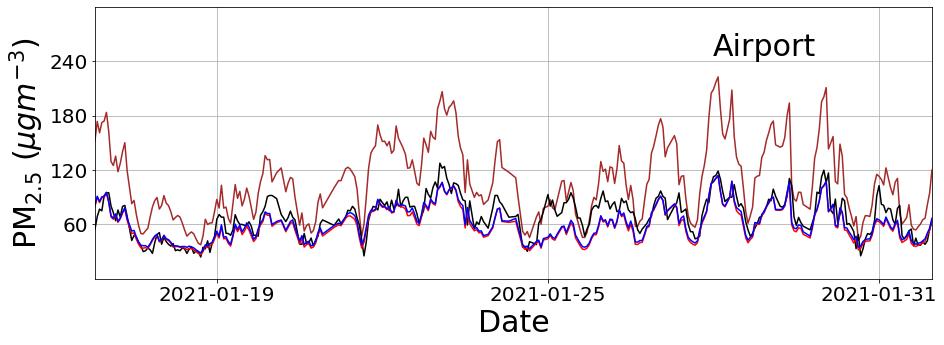

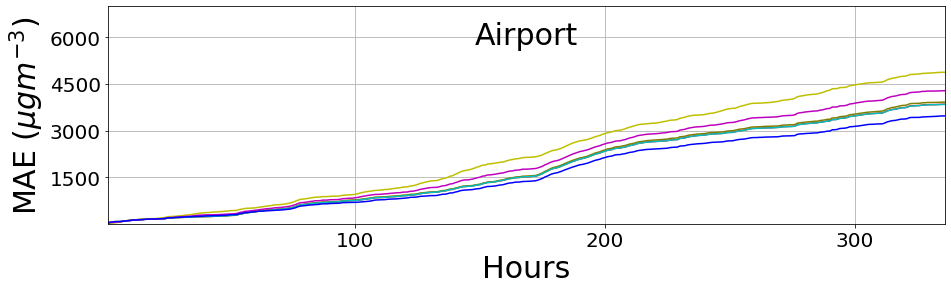

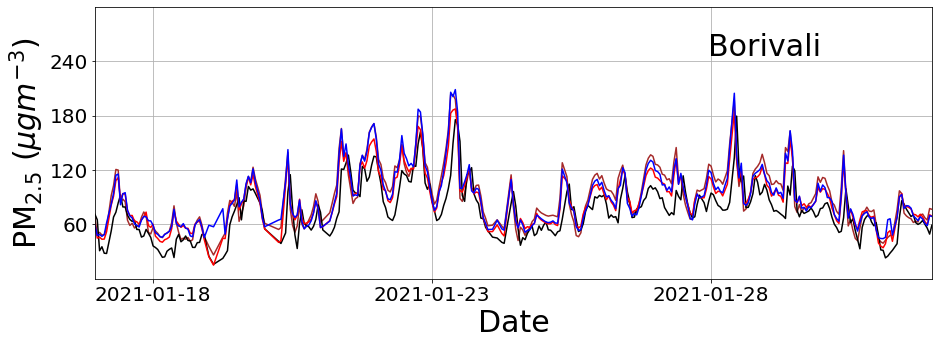

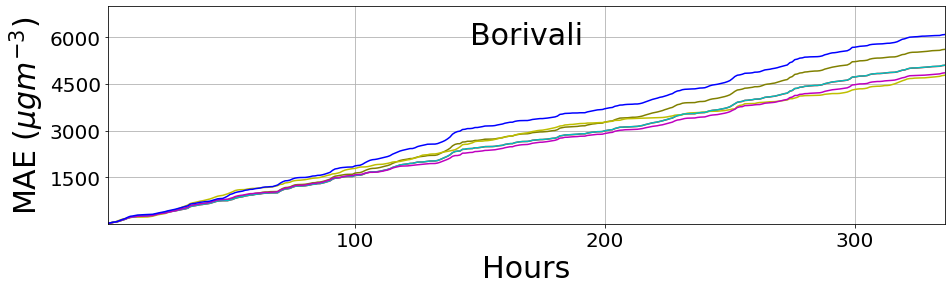

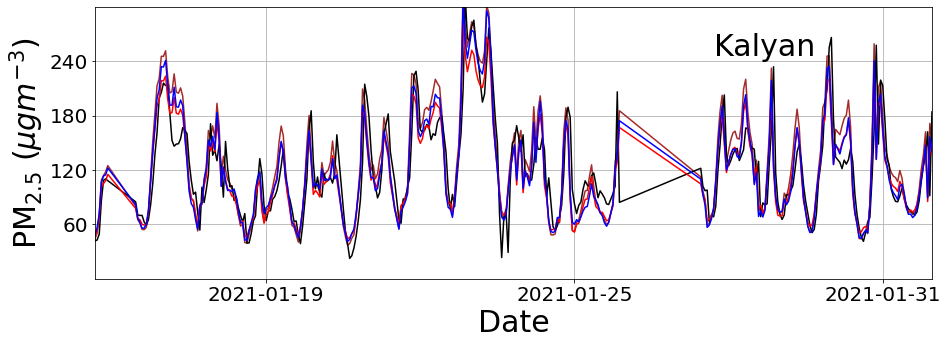

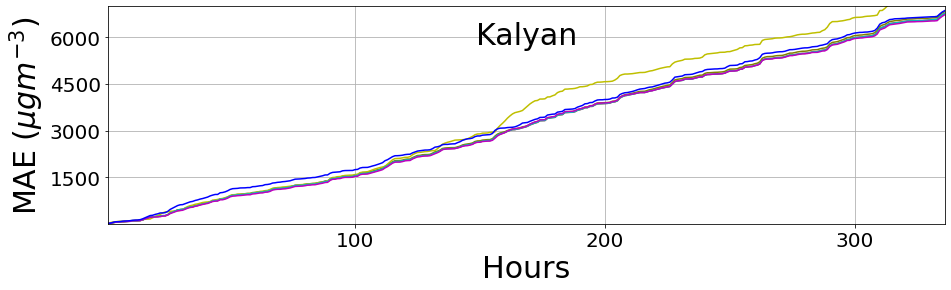

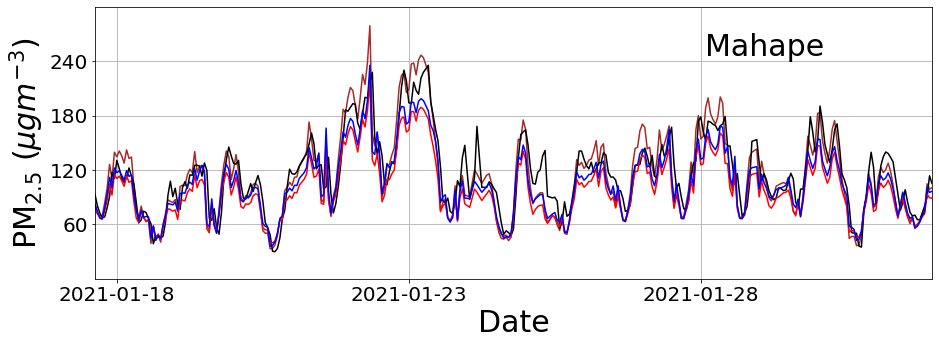

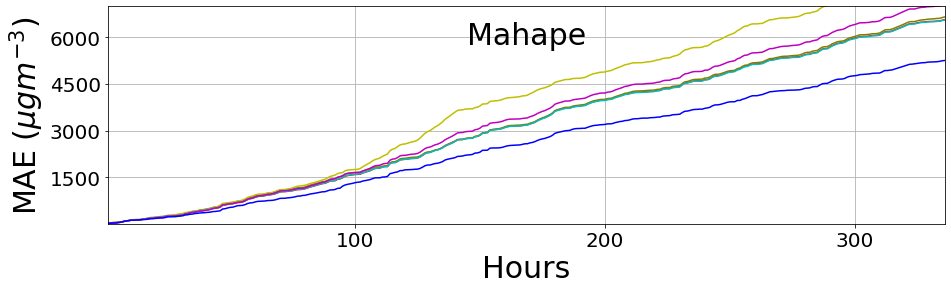

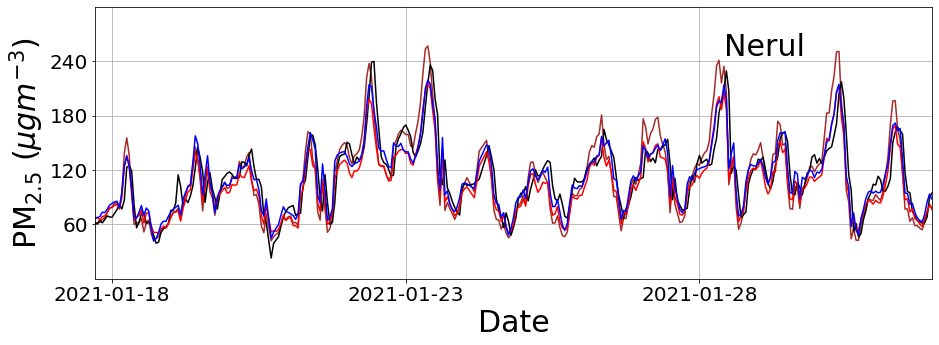

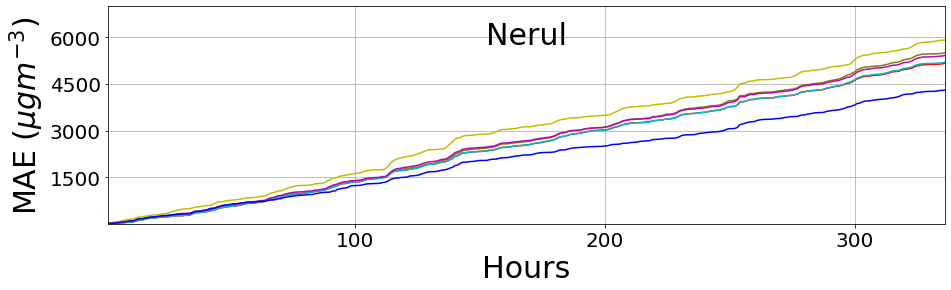

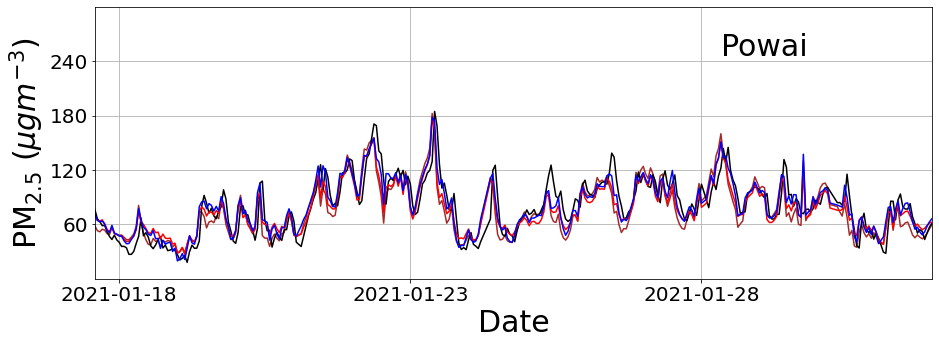

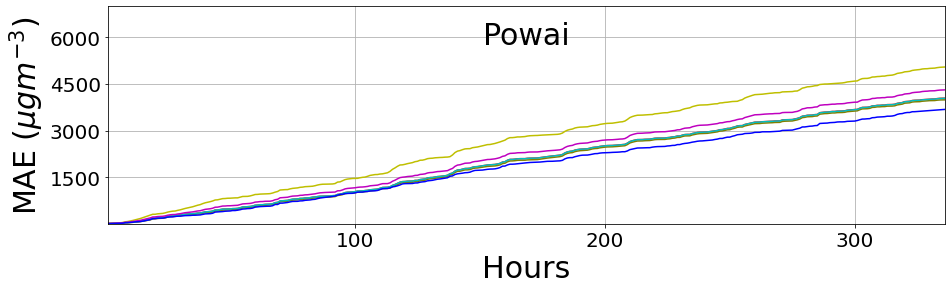

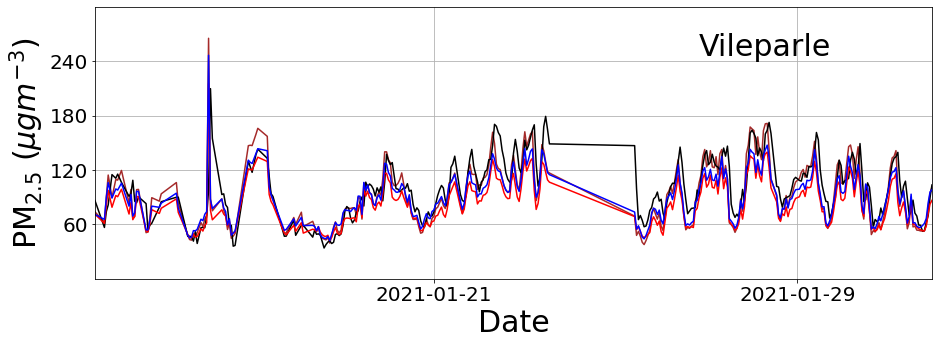

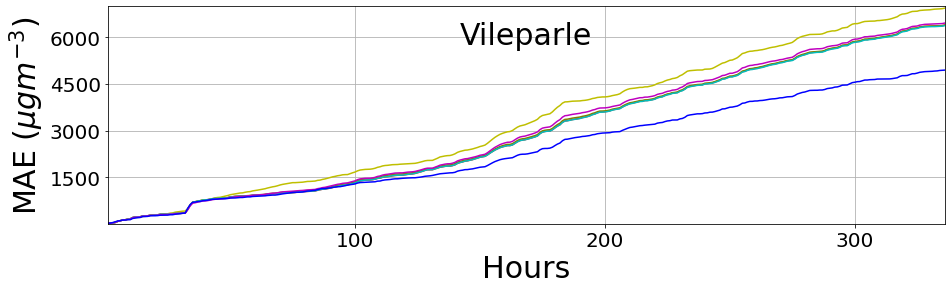

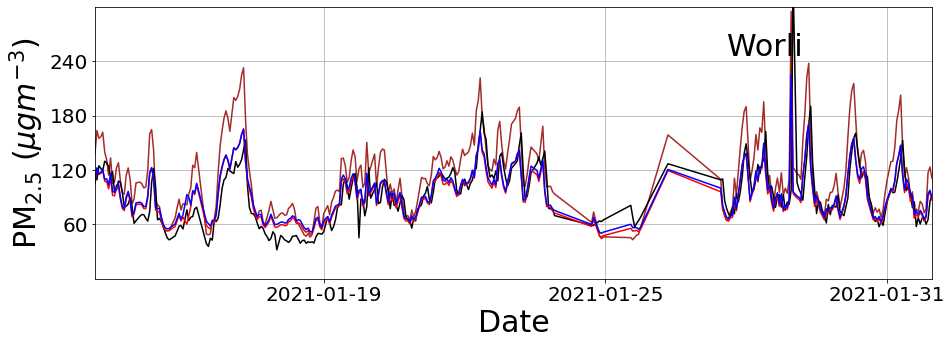

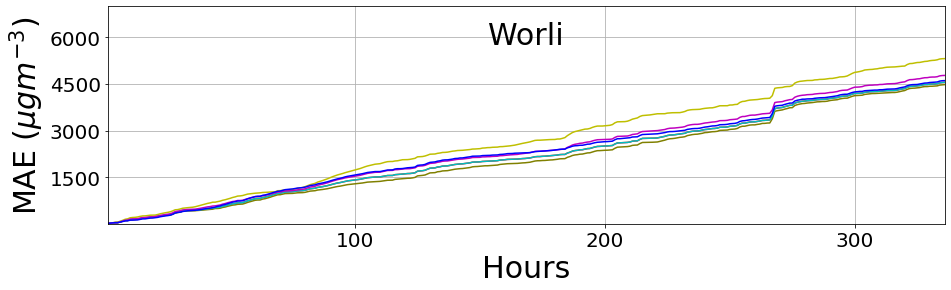

In [3]:
name_list = ['Airport','Borivali','Kalyan','Mahape','Nerul','Powai','Vileparle','Worli']
base_model(name_list)